# **KELOMPOK 4**
1. Muhammad Abrar Triyadi - 1305213046
2. Dely Rafael Sefriansya - 1305210086

Import data yang diperlukan

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import boxcox, levene
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
from scipy.stats import t
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy.stats import kstest, norm
from sklearn.metrics import mean_squared_error
from math import sqrt

Menghubungkan dengan google drive karena dataset disimpan di dalam google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Membaca Dataset

In [ ]:
df = pd.read_excel('/content/drive/My Drive/Dataset/4. Data Lama Penyinaran.xlsx')
df

,Tanggal,Lamanya Penyinaran Matahari (jam)
0,2017-11-01,8.6
1,2017-11-02,7.5
2,2017-11-03,7.3
3,2017-11-04,6.3
4,2017-11-05,2.7
...,...,...
1517,2021-12-27,5.8
1518,2021-12-28,5.6
1519,2021-12-29,6.0
1520,2021-12-30,3.0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1522 entries, 0 to 1521
Data columns (total 2 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   Tanggal                            1522 non-null   datetime64[ns]
 1   Lamanya Penyinaran Matahari (jam)  1519 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 23.9 KB


Terlihat bahwa terdapat 3 data yang bersifat null, hal ini harus dilakukan penangan terlebih dahulu karena akan mempengaruhi jalannya prediksi

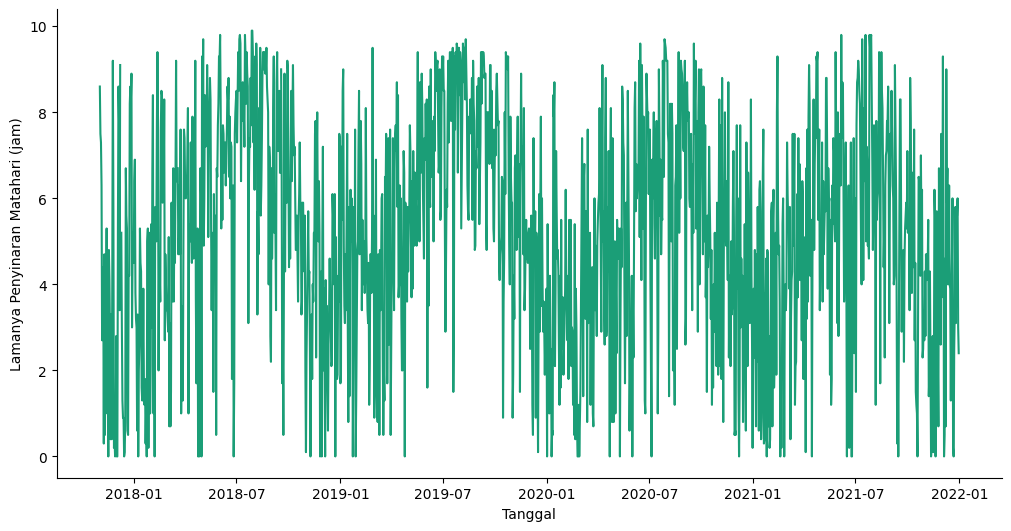

In [ ]:
#Plot Dataset
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Tanggal']
  ys = series['Lamanya Penyinaran Matahari (jam)']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df.sort_values('Tanggal', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Tanggal')
_ = plt.ylabel('Lamanya Penyinaran Matahari (jam)')

In [ ]:
#Interpolation
interpolate_lamanya_penyinaran = df['Lamanya Penyinaran Matahari (jam)'].interpolate()
df['Lamanya Penyinaran Matahari (jam)'] = df['Lamanya Penyinaran Matahari (jam)'].fillna(interpolate_lamanya_penyinaran)

Mengisi data yang bersifat null dengan metode interpolation. Interpolation sendiri merupakan sebuah teknik yang digunakan pada data time series untuk mengisi suatu nilai kosong atau null dengan melihat data sebelum dan sesudahnya.

In [ ]:
#Show Info Dataset After Interpolation
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1522 entries, 0 to 1521
Data columns (total 2 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   Tanggal                            1522 non-null   datetime64[ns]
 1   Lamanya Penyinaran Matahari (jam)  1522 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 23.9 KB


# **PERIKSA KESTASIONERAN DATA TERHADAP MEAN (UJI ADF)**

In [ ]:
# Menguji kestasioneran data terhadap mean menggunakan uji ADF
result = adfuller(df['Lamanya Penyinaran Matahari (jam)'])

# Menampilkan hasil uji ADF
print('ADF Statistic:', result[0])
print('P-Value:', result[1])
print('Critical Values:', result[4])

# Menentukan apakah hipotesis nol dapat ditolak
if result[1] <= 0.05:
    print("Kesimpulan: Tolak hipotesis nol, data stasioner terhadap mean")
else:
    print("Kesimpulan: Gagal tolak hipotesis nol, data tidak stasioner terhadap mean")

ADF Statistic: -3.84446658832959
P-Value: 0.0024837609398117083
Critical Values: {'1%': -3.4347199356122493, '5%': -2.86347004827819, '10%': -2.567797534300163}
Kesimpulan: Tolak hipotesis nol, data stasioner terhadap mean


# **PERIKSA KESTASIONERAN DATA TERHADAP VARIANSI (Box-Cox)**

In [ ]:
df['Lamanya Penyinaran Matahari (jam)'] = df['Lamanya Penyinaran Matahari (jam)'] + 1

# Menggunakan Box-Cox untuk transformasi
transformed_data, lambda_value = boxcox(df['Lamanya Penyinaran Matahari (jam)'])

karena terdapat data bernilai nol, maka sebelum dilakukan transformasi harus dilakukan penanganan terlebih dahulu sebelum di transformasi dengan menggunakan metode box-cox.

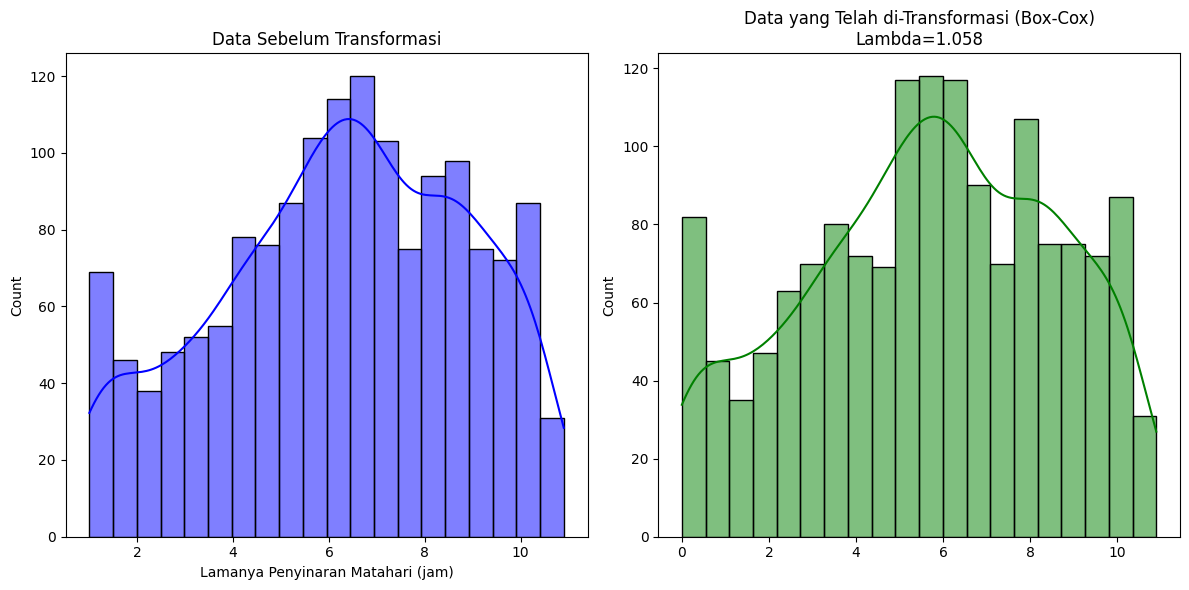

Uji Levene - Statistik: 16.935238493739416, P-Value: 3.970376986097338e-05
Kesimpulan: Tolak hipotesis nol data stasioner terhadap variansi
Nilai Lambda dari Transformasi Box-Cox: 1.0583168558044134


In [ ]:
# Plotting histogram untuk data asli dan data yang telah di-transformasi
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(df['Lamanya Penyinaran Matahari (jam)'], bins=20, kde=True, color='blue')
plt.title('Data Sebelum Transformasi')

plt.subplot(1, 2, 2)
sns.histplot(transformed_data, bins=20, kde=True, color='green')
plt.title(f'Data yang Telah di-Transformasi (Box-Cox)\nLambda={lambda_value:.3f}')  # Menambahkan nilai lambda ke judul

plt.tight_layout()
plt.show()

# Menguji kestasioneran variansi menggunakan uji Levene
statistic, p_value = stats.levene(df['Lamanya Penyinaran Matahari (jam)'], transformed_data)
print(f'Uji Levene - Statistik: {statistic}, P-Value: {p_value}')

# Menyimpulkan hasil berdasarkan p-value
if p_value <= 0.05:
    print('Kesimpulan: Tolak hipotesis nol data stasioner terhadap variansi')
else:
    print('Kesimpulan: Terima hipotesis nol data tidak stasioner terhadap variansi')

# Menampilkan nilai lambda dari transformasi Box-Cox
print(f'Nilai Lambda dari Transformasi Box-Cox: {lambda_value}')

Transformasi Box-Cox merupakan suatu metode transformasi data yang dibutuhkan jika data cenderung tidak stasioner dalam variansi, berdasarkan hasil terhadap Variansi, dan menggunakan α = 0.05, diperoleh bahwa p-value < α, sehingga tolak h0, dapat disimpulkan data teresebut stasioner dan variansi data asli tidak berubah seiring dengan waktu.

Nilai lambda dari transformasi Box-Cox menunjukkan jenis transformasi Box-Cox yang perlu digunakan untuk menstasionerkan data asli. Dalam hal ini, nilai lambda 1.0583168558044134 menunjukkan bahwa transformasi Box-Cox dengan lambda 1.0583168558044134 perlu digunakan untuk menstasionerkan data asli.

# **PLOT ACF DAN PACF**

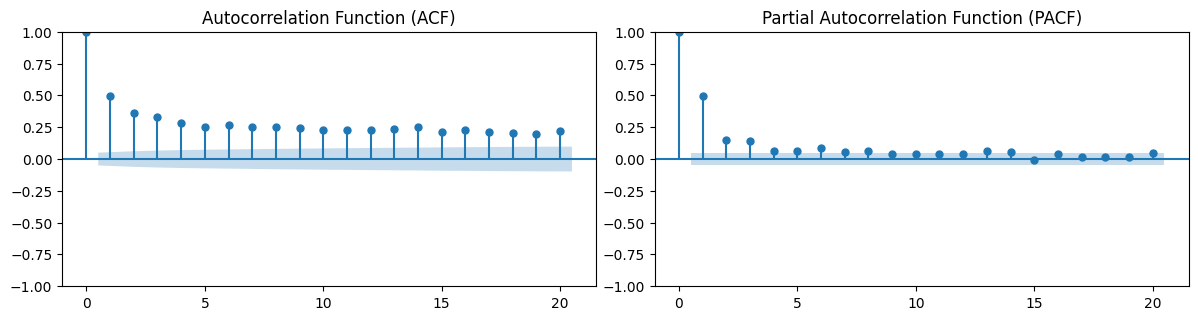

In [ ]:
# Membuat plot ACF dan PACF
plt.figure(figsize=(12, 6))

plt.subplot(2, 2, 1)
plot_acf(transformed_data, lags=20, ax=plt.gca())
plt.title('Autocorrelation Function (ACF)')

plt.subplot(2, 2, 2)
plot_pacf(transformed_data, lags=20, ax=plt.gca())
plt.title('Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.show()

In [ ]:
from statsmodels.tsa.stattools import acf, pacf

# Menghitung ACF dan PACF
acf_vals = acf(transformed_data, nlags=20)
pacf_vals = pacf(transformed_data, nlags=20)

# Menentukan batas cut-off
batas_cut_off = 1.96 / len(transformed_data) ** 0.5

# Identifikasi lag-lag yang melampaui batas cut-off pada ACF
cutoff_acf = [lag for lag in range(len(acf_vals)) if abs(acf_vals[lag]) > batas_cut_off]

# Identifikasi lag-lag yang melampaui batas cut-off pada PACF
cutoff_pacf = [lag for lag in range(len(pacf_vals)) if abs(pacf_vals[lag]) > batas_cut_off]

# Tampilkan hasil identifikasi
print('Lags yang melampaui batas cut-off pada ACF:', cutoff_acf)
print('Lags yang melampaui batas cut-off pada PACF:', cutoff_pacf)

Lags yang melampaui batas cut-off pada ACF: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Lags yang melampaui batas cut-off pada PACF: [0, 1, 2, 3, 4, 5, 6, 7, 8, 13, 14]


Berdasarkan
grafik plot ACF,
terlihat bahwa cut off terjadi
pada lag ke 0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
sehingga orde q yang dapat
dipilih adalah 0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20.
Sedangkan pada plot PACF,
cut off terjadi pada lag ke 0, 1, 2, 3, 4, 5, 6, 7, 8, 13, 14, sehingga orde p yang dapat
dipilih adalah 0, 1, 2, 3, 4, 5, 6, 7, 8, 13, 14.
Selanjutnya
akan dipilih model
terbaik berdasarkan nilai AIC
dari semua kombinasi
kemungkinan model yang
dapat dibentuk dari orde p
dan q


# **IDENTIFIKASI MODEL ARMA(p,q)**

In [ ]:
#ARMA Model Fitting
ar_orders = [0, 1, 2, 3, 4, 5, 6, 7, 8, 13, 14]
ma_orders = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
fitted_model_dict = {}
for i in range(len(ar_orders)):
  for j in range(len(ma_orders)):
    arma_model = ARIMA(df['Lamanya Penyinaran Matahari (jam)'], order = (ar_orders[i],0,ma_orders[j]))
    arma_model_fit = arma_model.fit()
    fitted_model_dict[(ar_orders[i],ma_orders[j])] = arma_model_fit

#AIC Result
for i in ar_orders:
  for j in ma_orders:
    print("AIC for 'AR(%s)MA(%s): %s"%(i, j,fitted_model_dict[(i, j)].aic))

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10

AIC for 'AR(0)MA(0): 7221.6913279056125
AIC for 'AR(0)MA(1): 6920.209687064111
AIC for 'AR(0)MA(2): 6856.444619904469
AIC for 'AR(0)MA(3): 6805.136203245513
AIC for 'AR(0)MA(4): 6781.470520918701
AIC for 'AR(0)MA(5): 6776.156631619613
AIC for 'AR(0)MA(6): 6766.519028106241
AIC for 'AR(0)MA(7): 6760.142305116125
AIC for 'AR(0)MA(8): 6753.849788160155
AIC for 'AR(0)MA(9): 6748.904963067016
AIC for 'AR(0)MA(10): 6747.078676130515
AIC for 'AR(0)MA(11): 6745.157304405182
AIC for 'AR(0)MA(12): 6745.176161112819
AIC for 'AR(0)MA(13): 6744.929077578023
AIC for 'AR(0)MA(14): 6734.346934173086
AIC for 'AR(0)MA(15): 6734.935045432922
AIC for 'AR(0)MA(16): 6733.707598432105
AIC for 'AR(0)MA(17): 6733.627675706563
AIC for 'AR(0)MA(18): 6734.566347781341
AIC for 'AR(0)MA(19): 6736.543984307955
AIC for 'AR(0)MA(20): 6738.53987604205
AIC for 'AR(1)MA(0): 6798.190720519172
AIC for 'AR(1)MA(1): 6728.907412607405
AIC for 'AR(1)MA(2): 6684.365832564707
AIC for 'AR(1)MA(3): 6678.824943540344
AIC for 'AR(1)

In [ ]:
# Sort model berdasarkan AIC
sorted_models = sorted(fitted_model_dict.items(), key=lambda x: x[1].aic, reverse=False)

# Ambil dua model dengan AIC terendah
best_models = sorted_models[:2]

# Tampilkan hasil AIC dua model terbaik
for model, aic in best_models:
    print(f"AR({model[0]})MA({model[1]}): AIC = {aic.aic}")

AR(7)MA(13): AIC = 6665.255150302998
AR(5)MA(14): AIC = 6666.872612270949


Model terbaik adalah model yang memiliki nilai AIC terkecil.
Dari beberapa kemungkinan model, nilai AIC Terlihat bahwa model ARMA(7, 13) memiliki nilai AIC terkecil, sehingga model ini merupakan model terbaik namun tidak menutup kemungkina terdapat model ARMA lainnya yang terbaik

# **ESTIMASI PARAMETER MENGGUNAKAN METODE MAXIMUM LIKELIHOOD, KEMUDIAN DIUJI SIGNIFIKANSI TERHADAP PARAMETER**

In [ ]:
# Model ARIMA(7,0,13)
model_arima_1 = sm.tsa.ARIMA(transformed_data, order=(7, 0, 13))
results_arima_1 = model_arima_1.fit()

# Ekstrak nilai parameter
params_1 = results_arima_1.params

# Ekstrak kesalahan standar
std_errors_1 = results_arima_1.bse

# Jumlah observasi
n_obs = len(transformed_data)

# Derajat kebebasan
df = n_obs - len(params_1)

# Nilai kritis dari distribusi t untuk taraf signifikansi 5%
t_critical = t.ppf(1 - 0.025, df)

# Uji signifikansi untuk model ARIMA(7, 0, 13)
print("Uji Signifikansi untuk Model ARMA(7, 0, 13):")
for i, (param, std_error) in enumerate(zip(params_1, std_errors_1)):
    t_statistic = param / std_error
    p_value = 2 * (1 - t.cdf(np.abs(t_statistic), df))
    significant = "Signifikan" if np.abs(t_statistic) > t_critical else "Tidak Signifikan"

    print(f"Parameter {i + 1}: t-statistic = {t_statistic:.4f}, p-value = {p_value:.4f}, {significant}")

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Uji Signifikansi untuk Model ARMA(7, 0, 13):
Parameter 1: t-statistic = 10.4211, p-value = 0.0000, Signifikan
Parameter 2: t-statistic = 0.2734, p-value = 0.7846, Tidak Signifikan
Parameter 3: t-statistic = -0.5567, p-value = 0.5778, Tidak Signifikan
Parameter 4: t-statistic = 0.9991, p-value = 0.3179, Tidak Signifikan
Parameter 5: t-statistic = -0.3287, p-value = 0.7424, Tidak Signifikan
Parameter 6: t-statistic = 0.8607, p-value = 0.3895, Tidak Signifikan
Parameter 7: t-statistic = -0.1910, p-value = 0.8486, Tidak Signifikan
Parameter 8: t-statistic = 0.6843, p-value = 0.4939, Tidak Signifikan
Parameter 9: t-statistic = 0.0033, p-value = 0.9974, Tidak Signifikan
Parameter 10: t-statistic = 0.5210, p-value = 0.6025, Tidak Signifikan
Parameter 11: t-statistic = -0.4629, p-value = 0.6435, Tidak Signifikan
Parameter 12: t-statistic = 0.2922, p-value = 0.7701, Tidak Signifikan
Parameter 13: t-statistic = -0.7410, p-value = 0.4588, Tidak Signifikan
Parameter 14: t-statistic = 0.0694, p-val

Pada model ARMA(7,13) ini dapat dilihat bahwa hasil uji signifikansi terhadap parameter hanya signifikan di 2 parameter yaitu parameter 1 dan parameter 22

In [ ]:
# Model ARIMA(5,0,14)
model_arima_2 = sm.tsa.ARIMA(transformed_data, order=(5, 0, 14))
results_arima_2 = model_arima_2.fit()

# Ekstrak nilai parameter
params_2 = results_arima_2.params

# Ekstrak kesalahan standar
std_errors_2 = results_arima_2.bse

# Jumlah observasi
n_obs = len(transformed_data)

# Derajat kebebasan
df = n_obs - len(params_2)

# Nilai kritis dari distribusi t untuk taraf signifikansi 5%
t_critical = t.ppf(1 - 0.025, df)

# Uji signifikansi untuk model ARIMA(5,0,14)
print("Uji Signifikansi untuk Model ARMA(5,0,14):")
for i, (param, std_error) in enumerate(zip(params_2, std_errors_2)):
    t_statistic = param / std_error
    p_value = 2 * (1 - t.cdf(np.abs(t_statistic), df))
    significant = "Signifikan" if np.abs(t_statistic) > t_critical else "Tidak Signifikan"

    print(f"Parameter {i + 1}: t-statistic = {t_statistic:.4f}, p-value = {p_value:.4f}, {significant}")

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Uji Signifikansi untuk Model ARMA(5,0,14):
Parameter 1: t-statistic = 15.4263, p-value = 0.0000, Signifikan
Parameter 2: t-statistic = -0.7547, p-value = 0.4505, Tidak Signifikan
Parameter 3: t-statistic = 31.3540, p-value = 0.0000, Signifikan
Parameter 4: t-statistic = 37.9812, p-value = 0.0000, Signifikan
Parameter 5: t-statistic = -1.4343, p-value = 0.1517, Tidak Signifikan
Parameter 6: t-statistic = -29.4824, p-value = 0.0000, Signifikan
Parameter 7: t-statistic = 8.0916, p-value = 0.0000, Signifikan
Parameter 8: t-statistic = -22.2226, p-value = 0.0000, Signifikan
Parameter 9: t-statistic = -27.6029, p-value = 0.0000, Signifikan
Parameter 10: t-statistic = -6.2356, p-value = 0.0000, Signifikan
Parameter 11: t-statistic = 13.1541, p-value = 0.0000, Signifikan
Parameter 12: t-statistic = 3.1168, p-value = 0.0019, Signifikan
Parameter 13: t-statistic = 1.7176, p-value = 0.0861, Tidak Signifikan
Parameter 14: t-statistic = 1.8883, p-value = 0.0592, Tidak Signifikan
Parameter 15: t-sta

Pada model ARMA(5,14) ini dapat dilihat bahwa hasil uji signifikansi terhadap parameter hanya signifikan di 11 parameter yaitu parameter 1, 3, 4, 6, 7, 8, 9, 10, 11, 12, dan 21

Jika dilihat dari jumlah parameter yang signifikan, Model ARMA(5,14) memiliki lebih banyak parameter yang signifikan dibandingkan dengan Model ARMA(7,13). Oleh karena itu, dari segi signifikansi parameter, Model ARMA(5,14) mungkin dianggap lebih baik.

# **UJI KELAYAKAN MODEL MENGGUNAKAN METODE LJUNG-BOX**

In [ ]:
# Best ARMA model fitting
best_order = (7, 0, 13)
best_model = ARIMA(transformed_data, order=best_order)
best_result = best_model.fit()

# Lakukan uji kelayakan Ljung-Box
residuals = best_result.resid
lags = 20  # Atur sesuai kebutuhan analisis Anda
ljung_box_results = acorr_ljungbox(residuals, lags=lags, return_df=True)

# Tampilkan hasil uji
for lag, p_value in zip(range(1, lags + 1), ljung_box_results['lb_pvalue']):
    print(f"Lag {lag}: p-value = {p_value}")

# Evaluasi hasil uji, jika p-value < alpha (tingkat signifikansi yang ditentukan), tolak H0
alpha = 0.05
if any(ljung_box_results['lb_pvalue'] < alpha):
    print("Terdapat korelasi residual yang signifikan.")
else:
    print("Tidak terdapat korelasi residual yang signifikan.")

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Lag 1: p-value = 0.9889042833186402
Lag 2: p-value = 0.9996487458150771
Lag 3: p-value = 0.9999923383058595
Lag 4: p-value = 0.9999996776903941
Lag 5: p-value = 0.9999999819681291
Lag 6: p-value = 0.9999999766641527
Lag 7: p-value = 0.9999975370016226
Lag 8: p-value = 0.9999996627443489
Lag 9: p-value = 0.9999973503599683
Lag 10: p-value = 0.9999990856672807
Lag 11: p-value = 0.9999974197509015
Lag 12: p-value = 0.9999992918294995
Lag 13: p-value = 0.9999984169834917
Lag 14: p-value = 0.9999943311331735
Lag 15: p-value = 0.9999800347268949
Lag 16: p-value = 0.9999925521555968
Lag 17: p-value = 0.9999958212819343
Lag 18: p-value = 0.9999956205978674
Lag 19: p-value = 0.9998385837459746
Lag 20: p-value = 0.9999188770948221
Tidak terdapat korelasi residual yang signifikan.


In [ ]:
# Best ARMA model fitting
best_order = (5, 0, 14)
best_model = ARIMA(transformed_data, order=best_order)
best_result = best_model.fit()

# Lakukan uji kelayakan Ljung-Box
residuals = best_result.resid
lags = 20  # Atur sesuai kebutuhan analisis Anda
ljung_box_results = acorr_ljungbox(residuals, lags=lags, return_df=True)

# Tampilkan hasil uji
for lag, p_value in zip(range(1, lags + 1), ljung_box_results['lb_pvalue']):
    print(f"Lag {lag}: p-value = {p_value}")

# Evaluasi hasil uji, jika p-value < alpha (tingkat signifikansi yang ditentukan), tolak H0
alpha = 0.05
if any(ljung_box_results['lb_pvalue'] < alpha):
    print("Terdapat korelasi residual yang signifikan.")
else:
    print("Tidak terdapat korelasi residual yang signifikan.")

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Lag 1: p-value = 0.43370617369538966
Lag 2: p-value = 0.7033007778515782
Lag 3: p-value = 0.7843454986487481
Lag 4: p-value = 0.8984110474890525
Lag 5: p-value = 0.895404760353052
Lag 6: p-value = 0.9434370134808981
Lag 7: p-value = 0.9696598643673182
Lag 8: p-value = 0.9831755221579943
Lag 9: p-value = 0.9893102413564601
Lag 10: p-value = 0.9950302763356283
Lag 11: p-value = 0.9977348000521132
Lag 12: p-value = 0.9989142158693263
Lag 13: p-value = 0.9985683947936221
Lag 14: p-value = 0.9983900497729808
Lag 15: p-value = 0.9992613897773037
Lag 16: p-value = 0.9996727432544866
Lag 17: p-value = 0.9996964813016364
Lag 18: p-value = 0.9998475297273022
Lag 19: p-value = 0.9994584009005562
Lag 20: p-value = 0.9984119872655429
Tidak terdapat korelasi residual yang signifikan.


Dari hasil uji kelayakan kedua model dapat dilihat bahwa pada model ARMA(5,14) nilai p-value pada lag 1, 2, dan 3 cenderung kecil dan tidak konsisten dengan nilai lag lainnya, sedangkan pada model ARMA(7,13) nilai p-value setiap lag konsisten.

# **KESIMPULAN MODEL YANG DIPILIH**

Jika dilihat dari estimasi parameter dan uji signifikansi, model ARMA(5,14) memiliki parameter signifikan yang lebih banyak ketimbang model ARMA(7,13). Tetapi saat dilakukan uji kelayakan model terlihat bahwa nilai p-value di setiap lag pada model ARMA(7,13) lebih konsisten dibandingkan dengan model ARMA(5,14) maka dari itu dapat disimpulkan bahwa model yang terbaik untuk dijadikan pembentukan prediksi adalah model **ARMA(7,13)**  

# **UJI KENORMALAN SISAAN DENGAN MENGGUNAKAN KOLMOGOROV-SMIRNOF**

Uji kenormalan sisaan digunakan untuk mengevaluasi apakah sisaan (residuals) dari model statistik atau regresi terdistribusi secara normal. Sisaan adalah selisih antara nilai yang diamati dan nilai yang diprediksi oleh model.

In [ ]:
# Spesifikasi order ARMA terbaik (dalam hal ini, (7, 0, 13))
order = (7, 0, 13)

# Estimasi model ARMA
model = sm.tsa.ARIMA(transformed_data, order=order)
results = model.fit()

# Dapatkan sisaan (residuals) dari model
residuals = results.resid

# Uji Kolmogorov-Smirnov
ks_statistic, ks_p_value = kstest(residuals, 'norm')

# Tampilkan hasil uji
print(f"KS Statistic: {ks_statistic}")
print(f"P-value: {ks_p_value}")

# Evaluasi hasil uji, jika p-value < alpha (tingkat signifikansi yang ditentukan), tolak H0
alpha = 0.05
if ks_p_value < alpha:
    print('P-value < 0.05: Sisaan tidak terdistribusi normal.')
else:
    print('P-value >= 0.05: Tidak cukup bukti untuk menolak asumsi normalitas sisaan.')

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


KS Statistic: 0.22167588790012382
P-value: 3.5809028736036626e-66
P-value < 0.05: Sisaan tidak terdistribusi normal.


Terlihat bahwa sisaan tidak berdistribusi normal, hal ini tidak menjadi masalah karena sebelumnya dalam uji kelayakan dengan Ljung-Box nilai p-value sudah konsisten dan model sudah layak.

# **FORECASTING & CEK NILAI RMSE**

Forecasting & cek nilai rmse untuk model ARIMA(7,0,13)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


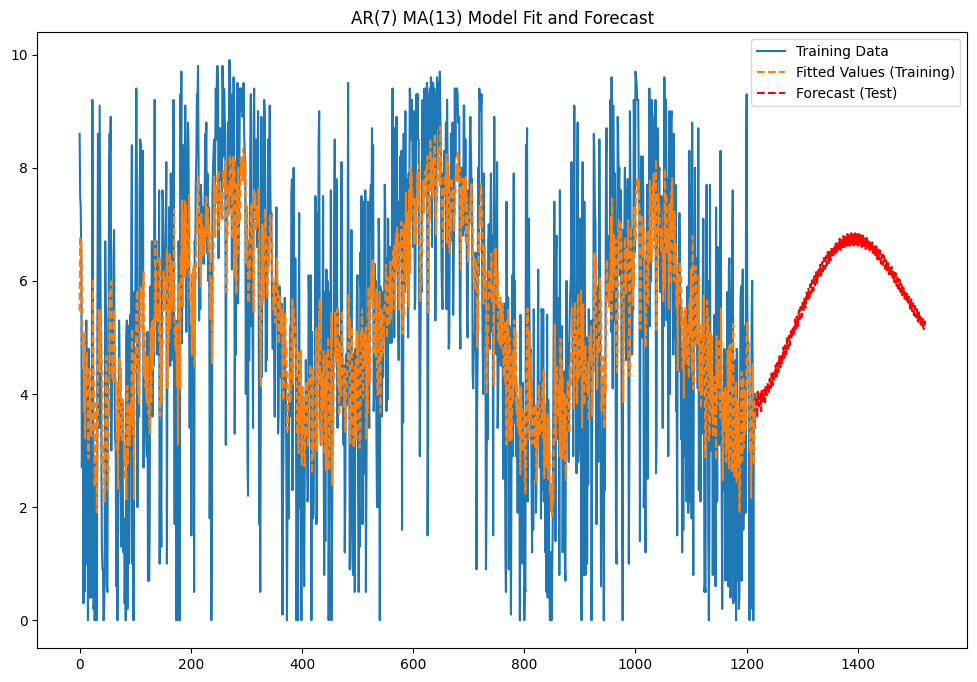

In [ ]:
# Assuming 'Tanggal' is the index of your DataFrame
train_size = int(len(df) * 0.8)
train, test = df['Lamanya Penyinaran Matahari (jam)'][:train_size], df['Lamanya Penyinaran Matahari (jam)'][train_size:]

# Specify the ARIMA order (7, 0, 13)
order = (7, 0, 13)

# Fit the ARIMA model on the training data
model = ARIMA(train, order=order)
fit_model = model.fit()

# Plot the observed data, fitted values on the training set, and forecast on the test set
plt.figure(figsize=(12, 8))
plt.plot(df.index[:train_size], train, label='Training Data')
plt.plot(df.index[:train_size], fit_model.fittedvalues, label='Fitted Values (Training)', linestyle='--')
plt.plot(df.index[train_size:], fit_model.get_forecast(steps=len(test)).predicted_mean, label='Forecast (Test)', linestyle='--', color='red')  # Adjusted color
# plt.plot(df.index[train_size:], test, label='Test Data', color='green')  # Adjusted color
plt.title(f'AR({order[0]}) MA({order[2]}) Model Fit and Forecast')
plt.legend()
plt.show()

In [ ]:
# Bagi data menjadi set pelatihan dan pengujian (misalnya, 80% untuk pelatihan, 20% untuk pengujian)
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]

# Tentukan model ARIMA dengan parameter (7,0,13)
model = ARIMA(train['Lamanya Penyinaran Matahari (jam)'], order=(7, 0, 13))
fit_model = model.fit()

# Lakukan forecasting untuk data pengujian
forecast = fit_model.get_forecast(steps=len(test))
forecast_values = forecast.predicted_mean

# Menghitung RMSE
actual_values = df['Lamanya Penyinaran Matahari (jam)'].iloc[train_size:]
rmse = sqrt(mean_squared_error(actual_values, forecast_values))

# Menampilkan hasil RMSE
print("\nRoot Mean Squared Error (RMSE):", rmse)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



Root Mean Squared Error (RMSE): 2.5578006589380893


Berdasarkan grafik yang ditampilkan terlihat bahwa model ARMA(7,13) mampu melakukan peramalan yang relatif akurat berdasarkan data yang telah diuji.